In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.models import Model
from keras.utils import to_categorical
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split

### Loading the Dataset

In [2]:
(X_train, y_train) , (X_test, y_test) = keras.datasets.mnist.load_data()

### Visualizing the Dataset

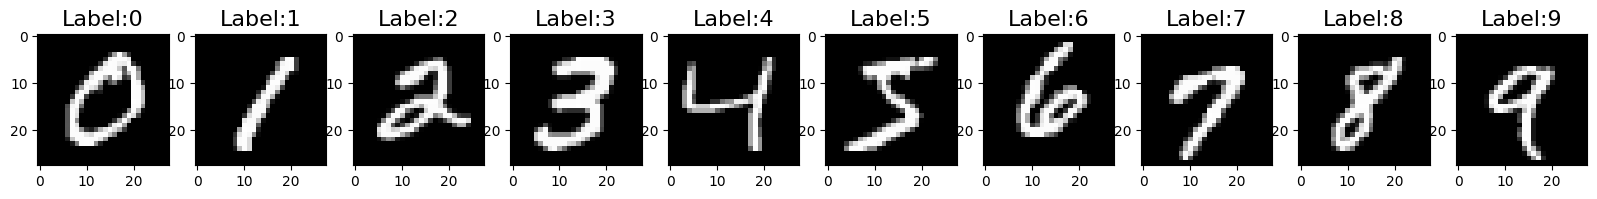

In [3]:
f, ax = plt.subplots(1,10,figsize=(20,20))

for i in range(0,10):
    sample=X_train[y_train==i][0]
    ax[i].imshow(sample, cmap='gray')
    ax[i].set_title(f"Label:{i}",fontsize=16)

In [4]:
X_train.shape

(60000, 28, 28)

### Preparing the Dataset

In [5]:
#normalizing
X_train = X_train / 255
X_test = X_test / 255

#adding an extra dimension
X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)
#
num_class=10
Y_train = to_categorical(y_train, num_classes = 10)
Y_test = to_categorical(y_test, num_classes = 10)


In [7]:
X_train.shape

(60000, 28, 28, 1)

### Building the model

In [8]:
model = Sequential()
#
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
#
model.add(Conv2D(filters = 24, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
# fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dense(10, activation = "softmax"))

x1 = model.layers[0]
x2 = model.layers[2]

x1w_before = x1.get_weights()[0][:,:,0,:]
x2w_before = x2.get_weights()[0][:,:,0,:]

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 24)        3480      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 24)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1176)              0         
                                                                 
 dense (Dense)               (None, 256)               3

### Compiling and Training the Model

In [9]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [10]:
history = model.fit(X_train, Y_train, epochs=5)

x1 = model.layers[0]
x2 = model.layers[2]

x1w_after = x1.get_weights()[0][:,:,0,:]
x2w_after = x2.get_weights()[0][:,:,0,:]

Epoch 1/5
1875/1875 [==============================] - 29s 14ms/step - loss: 0.1378 - accuracy: 0.9568
Epoch 2/5
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0439 - accuracy: 0.9862
Epoch 3/5
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0307 - accuracy: 0.9900
Epoch 4/5
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0223 - accuracy: 0.9931
Epoch 5/5
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0173 - accuracy: 0.9944


In [ ]:
plt.plot(history.history['accuracy'])

1/1 [==============================] - 0s 169ms/step


C:\Users\Dabehkun\AppData\Local\Temp\ipykernel_61628\4058994221.py:31: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()
C:\Users\Dabehkun\AppData\Local\Temp\ipykernel_61628\4058994221.py:34: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


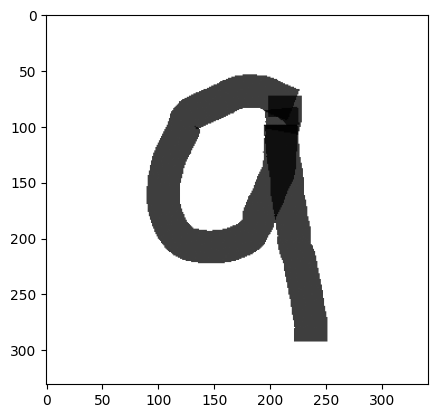

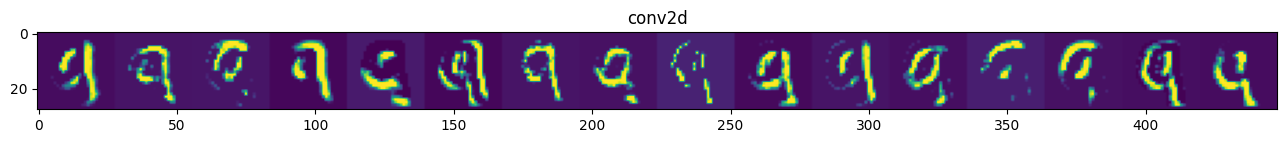

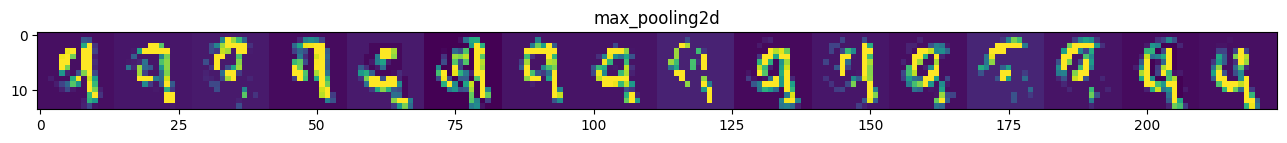

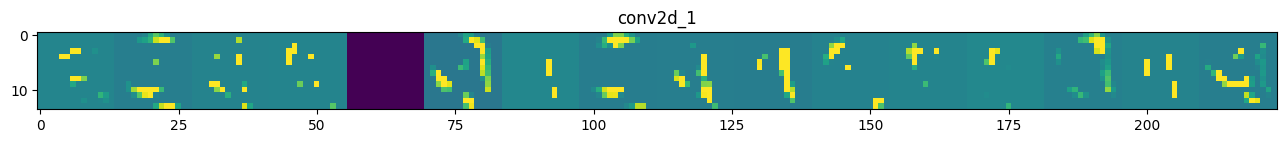

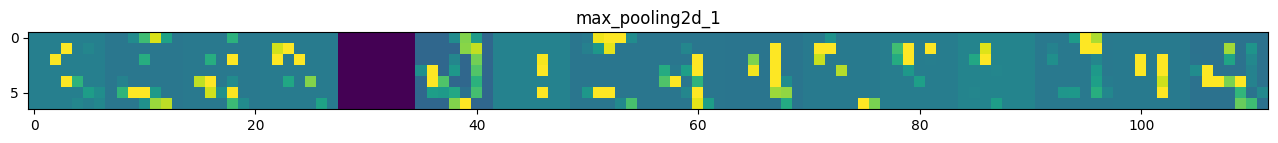

In [16]:
layer_outputs = [layer.output for layer in model.layers[0:7]]
activation_model = Model(inputs=model.input,outputs=layer_outputs)

import cv2
#read our live_test_draw
img_live = cv2.imread("live_test_draw.png")
gray_img = cv2.cvtColor(img_live, cv2.COLOR_BGR2GRAY)
resized_img = cv2.resize(gray_img, (28, 28))

plt.imshow(gray_img,cmap="gray")
img_final = (255-resized_img.reshape(1,28,28,1))/255
activations = activation_model.predict(img_final)

#display kernel outputs
layer_names = []
for layer in model.layers[0:4]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

### Prediction of our Model

In [17]:
model.predict(img_final).argmax()

1/1 [==============================] - 0s 43ms/step


9

### Evaluating our Model

In [ ]:
model.evaluate(X_test,Y_test)

### Untrained Convolution Kernels

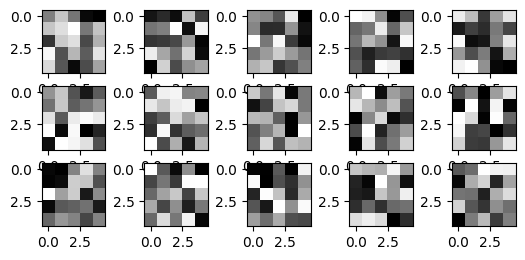

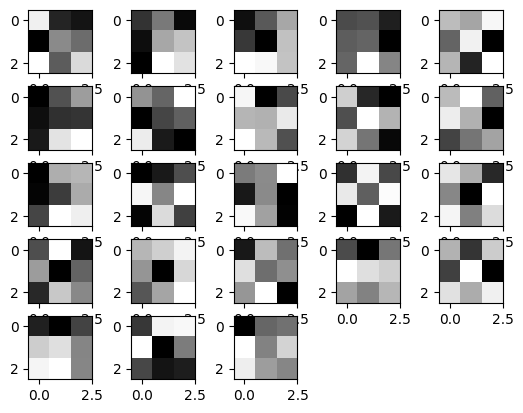

In [13]:
for i in range(1,16):
    plt.subplot(5,5,i)
    plt.imshow(x1w_before[:,:,i],interpolation="nearest",cmap="gray")
plt.show()

for i in range(1,24):
    plt.subplot(5,5,i)
    plt.imshow(x2w_before[:,:,i],interpolation="nearest",cmap="gray")
plt.show()


### Trained Convolution Kernels

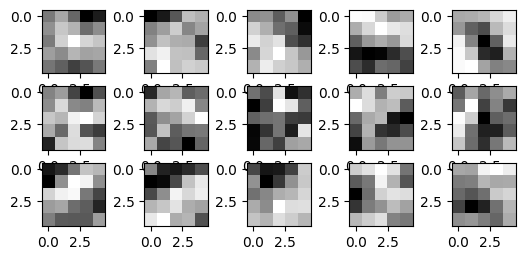

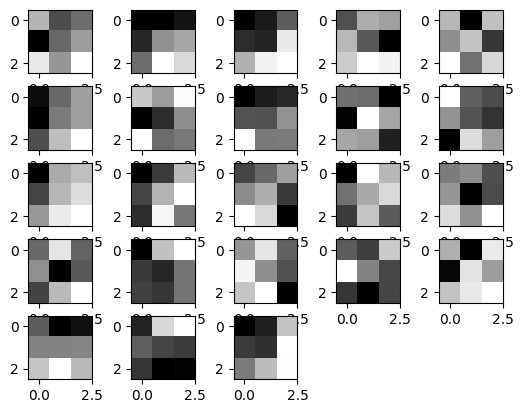

In [14]:
for i in range(1,16):
    plt.subplot(5,5,i)
    plt.imshow(x1w_after[:,:,i],interpolation="nearest",cmap="gray")
plt.show()

for i in range(1,24):
    plt.subplot(5,5,i)
    plt.imshow(x2w_after[:,:,i],interpolation="nearest",cmap="gray")
plt.show()
